**Introduction**

The task is to predict whether a passenger in an airport could be a Threat because he could have any kind of dangerous object ( gun, knifes ...). This objects could be detected by a millimetre wave scanner called the High Definition-Advanced Imaging Technology (HD-AIT) system.
The scanner generates a complete set of body scanner images and we want to find any kind of anomalies in the image it could think us that the passenger could have an object and it could be a threat for the rest of passengers.
We are going to apply clustering techniques for detection of anomalies in the image, and previously we are going to generate a complete training dataset with image that we are viewed before checking that the passenger don't have any kind of internal object.

In [1]:
import sys
import os
import numpy as np
from numpy import array, asarray, ma, zeros, sum
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
try:
    print(check_output(["ls", "../input"]).decode("utf8"))
    os.system('mkdir ./output')
    os.system('mkdir ./output/Threats')
    os.system('mkdir ./output/NoThreats')
    os.system('mkdir ./training')
    os.system('mkdir ./results')
    os.system('mkdir ./models')
    os.system('mkdir ./input')
    print(check_output(["ls", "../input/datainput"]).decode("utf8"))
    print(check_output(["ls", "../input/modelstraining"]).decode("utf8"))
    print(check_output(["ls", "../input/highresolution"]).decode("utf8"))
    print(check_output(["ls", "../input/modeldbscan"]).decode("utf8"))

except Exception as exc:
    print("Exception: {0}".format(exc))
# Any results you write to the current directory are saved as output.

highresolution
low-resolution
modeldbscan
modelstraining
passenger-screening-algorithm-challenge

Exception: Command '['ls', '../input/datainput']' returned non-zero exit status 2.


**Analysis Approach**
This original dataset contains a large number of body scans acquired by a new generation of millimetre wave scanner called the High Definition-Advanced Imaging Technology (HD-AIT) system. I considered the application of clustering techniques such as k-means and DBSCAN to generate a csv files with data that could be useful to do detect possible threats and marking the body zones scanned with possibles anomalies across the the careful analysis of distortion parameters in k-means techniques and the statistics parameters produced by  the application of DBSCAN techniques

In [3]:
PATH_PHOTO_FILES = '.'
NAME_FILE_MODEL_KMEANS = '../input/modelstraining/model_kmeans.csv'
NAME_FILE_MODEL_DBSCAN = '../input/modeldbscan/model_dbscan.csv'
DATA_FOR_PREDICTION_FILE = '../input/low-resolution/low_quality.csv'
DATA_FOR_PREDICTION_FILE_FILTERED = '../input/highresolution/high_quality.csv'

In [4]:
############################################################################################################
# Name: cluster_analisys
# Autor: Ramiro Bueno Martínez
# Date: 27/11/2017
##########################################################################################################
def cluster_analisys(subset):
	try:
		whitened = whiten(subset)
		codebook,distortion = kmeans(whitened,5)
		return distortion,whitened,codebook
	except Exception as exception:
		print ("cluster_analisys: Excepcion {0}".format(exception))

In [5]:
############################################################################################################
# Name: creation_dataset_dbscan
# Autor: Ramiro Bueno Martínez
# Date: 30/11/2017
# Description: The goal of fthis function is the dbscan analysis an generate a group of statistic datas
# usuful in the building of a model training for finding possibles anomalies in the image 
############################################################################################################
def creation_dataset_dbscan(dataset, FILENAME,highcontrast=False):
	try:
		output_dir = PATH_PHOTO_FILES + '/' + 'output'
		input_dir = PATH_PHOTO_FILES + '/' + 'input'
		name_of_photo_file =  FILENAME
		print("Starting creaction dataset dbscan {0}".format(name_of_photo_file))
		range_images = [0,4,8,12]
		m_homegeneity = 0
		for nth in range_images:
			an_img = get_single_image(name_of_photo_file, nth)  				#returns the nth=3 image from the image stack
			if highcontrast == True:
				img_rescaled = convert_to_grayscale(an_img)
				an_img = spread_spectrum(img_rescaled)
			data_array = np.array(an_img)
			whitened = whiten(data_array)
			record = pd.DataFrame({'x_axes': whitened[:, 0],'y_axes':whitened[:, 1]})
			centers = np.array(record)
			X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
			X = StandardScaler().fit_transform(X)
			db = DBSCAN(eps=0.3, min_samples=10).fit(X)
			core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
			core_samples_mask[db.core_sample_indices_] = True
			labels = db.labels_
			n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
			Name = FILENAME
			nClusters = n_clusters_
			Homegeneity = metrics.homogeneity_score(labels_true, labels)
			m_homegeneity = m_homegeneity + Homegeneity
			Completeness = 	metrics.completeness_score(labels_true, labels)
			Vmeasure = metrics.v_measure_score(labels_true, labels)
			ARIndex = metrics.adjusted_rand_score(labels_true, labels)
			AMInformation = 	metrics.adjusted_mutual_info_score(labels_true, labels)
			SilCoefficient = metrics.silhouette_score(X, labels)
			Threat = 'nothreat'
			record_dbscan = pd.DataFrame([[Name, nClusters, Homegeneity, Completeness, Vmeasure, ARIndex, AMInformation, SilCoefficient, Threat]],columns=['Name','nClusters','Homegeneity','Completeness','Vmeasure','ARIndex','AMInformation','SilCoefficient','Threat'])
			dataset = dataset.append(record_dbscan,ignore_index=True)
			
		media = 0
		media = m_homegeneity / 4
		percent = 5  # 5% of the mean value we suppose that its a wrong value 
		threshold_thread = media * percent / 100
		for i in range(len(dataset)):
			if abs(media - dataset.loc[i,('Homegeneity')]) > threshold_thread: 
				print("Finded a possible case")
				dataset.loc[i,('Threat')] = 'threat'
			if abs(media - dataset.loc[i,('Homegeneity')]) <= threshold_thread:
				dataset.loc[i,('Threat')] = 'nothreat'
	except Exception as ex:
		print("Exception: {0}".format(ex))
		sys.exit(-1)
	finally:
		return dataset


In [6]:
############################################################################################################
# Name: creation_dataset_threats
# Autor: Ramiro Bueno Martínez
# Date: 27/11/2017
# Description: The goal of this function is the finding of possible anomalies in the different kind of
# images generated with the body scannes, using clustering techniques based in the analysis of different
# part of the body and different possition imagees
############################################################################################################
def creation_dataset_threats(dataset, FILENAME, highcontrast=False):
		m_distortion = 0
		col = 0
		row = 0
		nth = 0
		output_dir = PATH_PHOTO_FILES + '/' + 'output'
		input_dir = PATH_PHOTO_FILES + '/' + 'input'
		name_of_photo_file = FILENAME
		print ("Starting clustering Analisys: {0}".format(FILENAME))
		range_images = [0,4,8,12]
		try:
			for nth in range_images:
				an_img = get_single_image(name_of_photo_file, nth)  				#returns the nth=3 image from the image stack
				if highcontrast == True:
					img_rescaled = convert_to_grayscale(an_img)
					an_img = spread_spectrum(img_rescaled)
				data_array = np.array(an_img)
				distortion_array[nth,1],whitened,codebook= cluster_analisys(data_array)
				m_distortion = m_distortion + distortion_array[nth,1]
				record = pd.DataFrame([[FILENAME, nth, distortion_array[nth,1],'nothreat']],columns=['Name','Nth','Distortion','Threat'])
				dataset = dataset.append(record,ignore_index=True)
				col = col + 1
				if col % 4 == 0:
					row = row + 1
					col = 0
				print(".")
			media = 0
			media = m_distortion / 4
			percent = 17  # 17% of the mean value we suppose that its a wrong value 
			threshold_thread = media * percent / 100
			for i in range(len(dataset)):
				if abs(media - dataset.loc[i,('Distortion')]) > threshold_thread: 
					dataset.loc[i,('Threat')] = 'threat'
				if abs(media - dataset.loc[i,('Distortion')]) <= threshold_thread:
					dataset.loc[i,('Threat')] = 'nothreat'
		except Exception as exception:
			print ("Function [creation_dataset_threats]: Excepcion {0}".format(exception))
			sys.exit(1)
		finally:
			return dataset


In [7]:
############################################################################################################
# Name: creation_dataset_threats
# Autor: Ramiro Bueno Martínez
# Date: 27/11/2017
# Description: The goal of this function is the finding of possible anomalies in the different kind of
# images generated with the body scannes, using clustering techniques based in the analysis of different
# part of the body and different possition imagees
############################################################################################################
def creation_dataset_threats(dataset, FILENAME, highcontrast=False):
		m_distortion = 0
		col = 0
		row = 0
		nth = 0
		output_dir = PATH_PHOTO_FILES + '/' + 'output'
		input_dir = PATH_PHOTO_FILES + '/' + 'input'
		name_of_photo_file = input_dir + '/' + FILENAME
		print ("Starting clustering Analisys: {0}".format(FILENAME))
		range_images = [0,4,8,12]
		try:
			for nth in range_images:
				an_img = get_single_image(name_of_photo_file, nth)  
				if highcontrast == True:
					img_rescaled = convert_to_grayscale(an_img)
					an_img = spread_spectrum(img_rescaled)
				data_array = np.array(an_img)
				distortion_array[nth,1],whitened,codebook= cluster_analisys(data_array)
				m_distortion = m_distortion + distortion_array[nth,1]
				record = pd.DataFrame([[FILENAME, nth, distortion_array[nth,1],'nothreat']],columns=['Name','Nth','Distortion','Threat'])
				dataset = dataset.append(record,ignore_index=True)
				col = col + 1
				if col % 4 == 0:
					row = row + 1
					col = 0
				print(".")
			media = 0
			media = m_distortion / 4
			percent = 17  # 17% of the mean value we suppose that its a wrong value 
			threshold_thread = media * percent / 100
			for i in range(len(dataset)):
				if abs(media - dataset.loc[i,('Distortion')]) > threshold_thread: 
					dataset.loc[i,('Threat')] = 'threat'
				if abs(media - dataset.loc[i,('Distortion')]) <= threshold_thread:
					dataset.loc[i,('Threat')] = 'nothreat'
		except Exception as exception:
			print ("Function [creation_dataset_threats]: Excepcion {0}".format(exception))
			sys.exit(1)
		finally:
			return dataset

In [8]:
####################################################################################################
# Name: print_screen_results
# Autor: Ramiro Bueno Martínez
# Date : 28/11/2017
# Description: Function that plot the results obtained in 4 graphis
# Graphic 1 - The body scan image of the people
# Graphic 2 - Adaptative Histogram Equalization of the image
# Graphic 3 - Graphic results after the image matrix of datas had been analysed with the k-means algorithm
# Graphic 4 - Graphic results after the image matrix of datas had been analysed with the DBSCAN algorithm
# Parameter: 
# Input: Image File
# Output: 
#	Parameter1: Record k-means data analysis
#	Parameter2: Record dbscan data analysis
###########################################################################################################

def print_screen_results(image):
	COLORMAP = 'pink'
	fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(50, 25))
	axarr[0,0].set_title('Body Scanner Image')
	axarr[0,0].imshow(image, cmap=COLORMAP)
	axarr[0,1].set_title('Adaptive Histogram Equalization')
	axarr[0,1].hist(image.flatten(), bins=256, color='c')
	data_array = np.array(image)
	whitened = whiten(data_array)
	codebook,distortion = kmeans(whitened,5)
	axarr[1,0].scatter(whitened[:, 0], whitened[:, 1], c='b')
	axarr[1,0].scatter(codebook[:, 0], codebook[:, 1], c='r')
	stream = 'k-means analyis: Distortion {0}%'.format(distortion)
	axarr[1,0].set_title(stream)
	record_kmeans = pd.DataFrame([[' ', 0, distortion,'nothreat']],columns=['Name','Nth','Distortion','Threat'])
	whitened = whiten(data_array)
	record = pd.DataFrame({'x_axes': whitened[:, 0],'y_axes':whitened[:, 1]})
	centers = np.array(record)
	X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
	X = StandardScaler().fit_transform(X)
	db = DBSCAN(eps=0.3, min_samples=10).fit(X)
	core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
	core_samples_mask[db.core_sample_indices_] = True
	labels = db.labels_
	n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
	plt.subplot(224)
	unique_labels = set(labels)
	colors = [plt.cm.Spectral(each)	for each in np.linspace(0, 1, len(unique_labels))]
	for k, col in zip(unique_labels, colors):
		if k == -1:
			col = [0, 0, 0, 1]
		class_member_mask = (labels == k)
		xy = X[class_member_mask & core_samples_mask]
		plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
			markeredgecolor='k', markersize=14)
		xy = X[class_member_mask & ~core_samples_mask]
		plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
			markeredgecolor='k', markersize=6)
		Name = ''
		nClusters = n_clusters_
		Homegeneity = metrics.homogeneity_score(labels_true, labels)
		Completeness = 	metrics.completeness_score(labels_true, labels)
		Vmeasure = metrics.v_measure_score(labels_true, labels)
		ARIndex = metrics.adjusted_rand_score(labels_true, labels)
		AMInformation = 	metrics.adjusted_mutual_info_score(labels_true, labels)
		SilCoefficient = metrics.silhouette_score(X, labels)
		Threat = 'nothreat'
		record_dbscan = pd.DataFrame([[Name, nClusters, Homegeneity, Completeness, Vmeasure, ARIndex, AMInformation, SilCoefficient, Threat]],columns=['Name','nClusters','Homegeneity','Completeness','Vmeasure','ARIndex','AMInformation','SilCoefficient','Threat'])
	plt.show()
	return record_kmeans, record_dbscan


In [9]:
def print_img(image,title='Image'):
	
	fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
	axarr[0].imshow(image, cmap='pink')			#Put in the screen the image after adaptative histogram equialization
	plt.subplot(122)
	plt.hist(image.flatten(), bins=256, color='c')
	plt.title(title)
	plt.xlabel('Adaptive Histogram Equalization')
	plt.ylabel('Frequency')
	plt.show()
	
	return image

**Results SECTION 1: Prediction with svm algorithm**

The first stage of our study is the generation of a complete training dataset with information about the possible threats detected in image. We are going to generate different kind of dataset (csv files) with distortion of the image parameters with respect to the mean of typical parameters obtained in images that we are checked that it hasn't presented any kind of threat using the next field parameters: 

      ['Name','Nth','Difference','Distortion', 'Mean', 'Threat']
 
With the application of k-means algorithm we can obtain the distortion with respect to 5 cluster centroid in the measurement, this parameter it's analysed with respect to the sum of the mean value and an initial threshold, when the parameter it's out of this margins we are considered that we could have a possible anomaly that it's necessary to analyse deeply. 

To check the training dataset we are going to use a classification method (support vector machine) to do a prediction about of possibles anomalies in the image, and detect a threat in the passenger. 

This is a very simple approach with ncluster, 5 initial cluster


DATA_ANALISIS_TOOL: Initialization of the system...


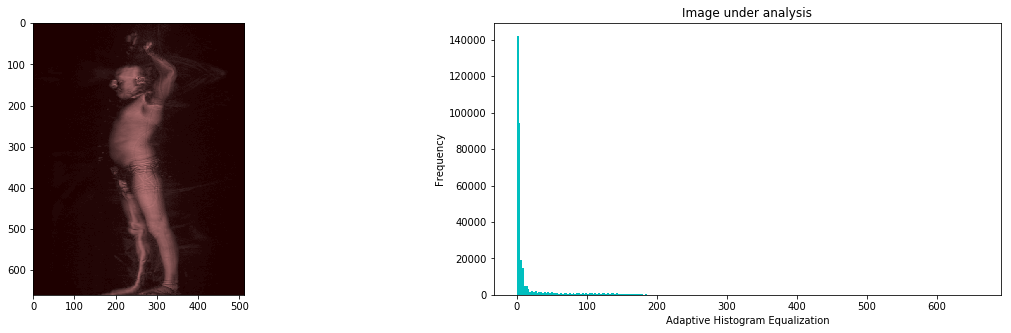

/opt/conda/lib/python3.6/site-packages/scipy/cluster/vq.py:141: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


Passenger low-resolution it could suppose a thread at Body Scanner 3


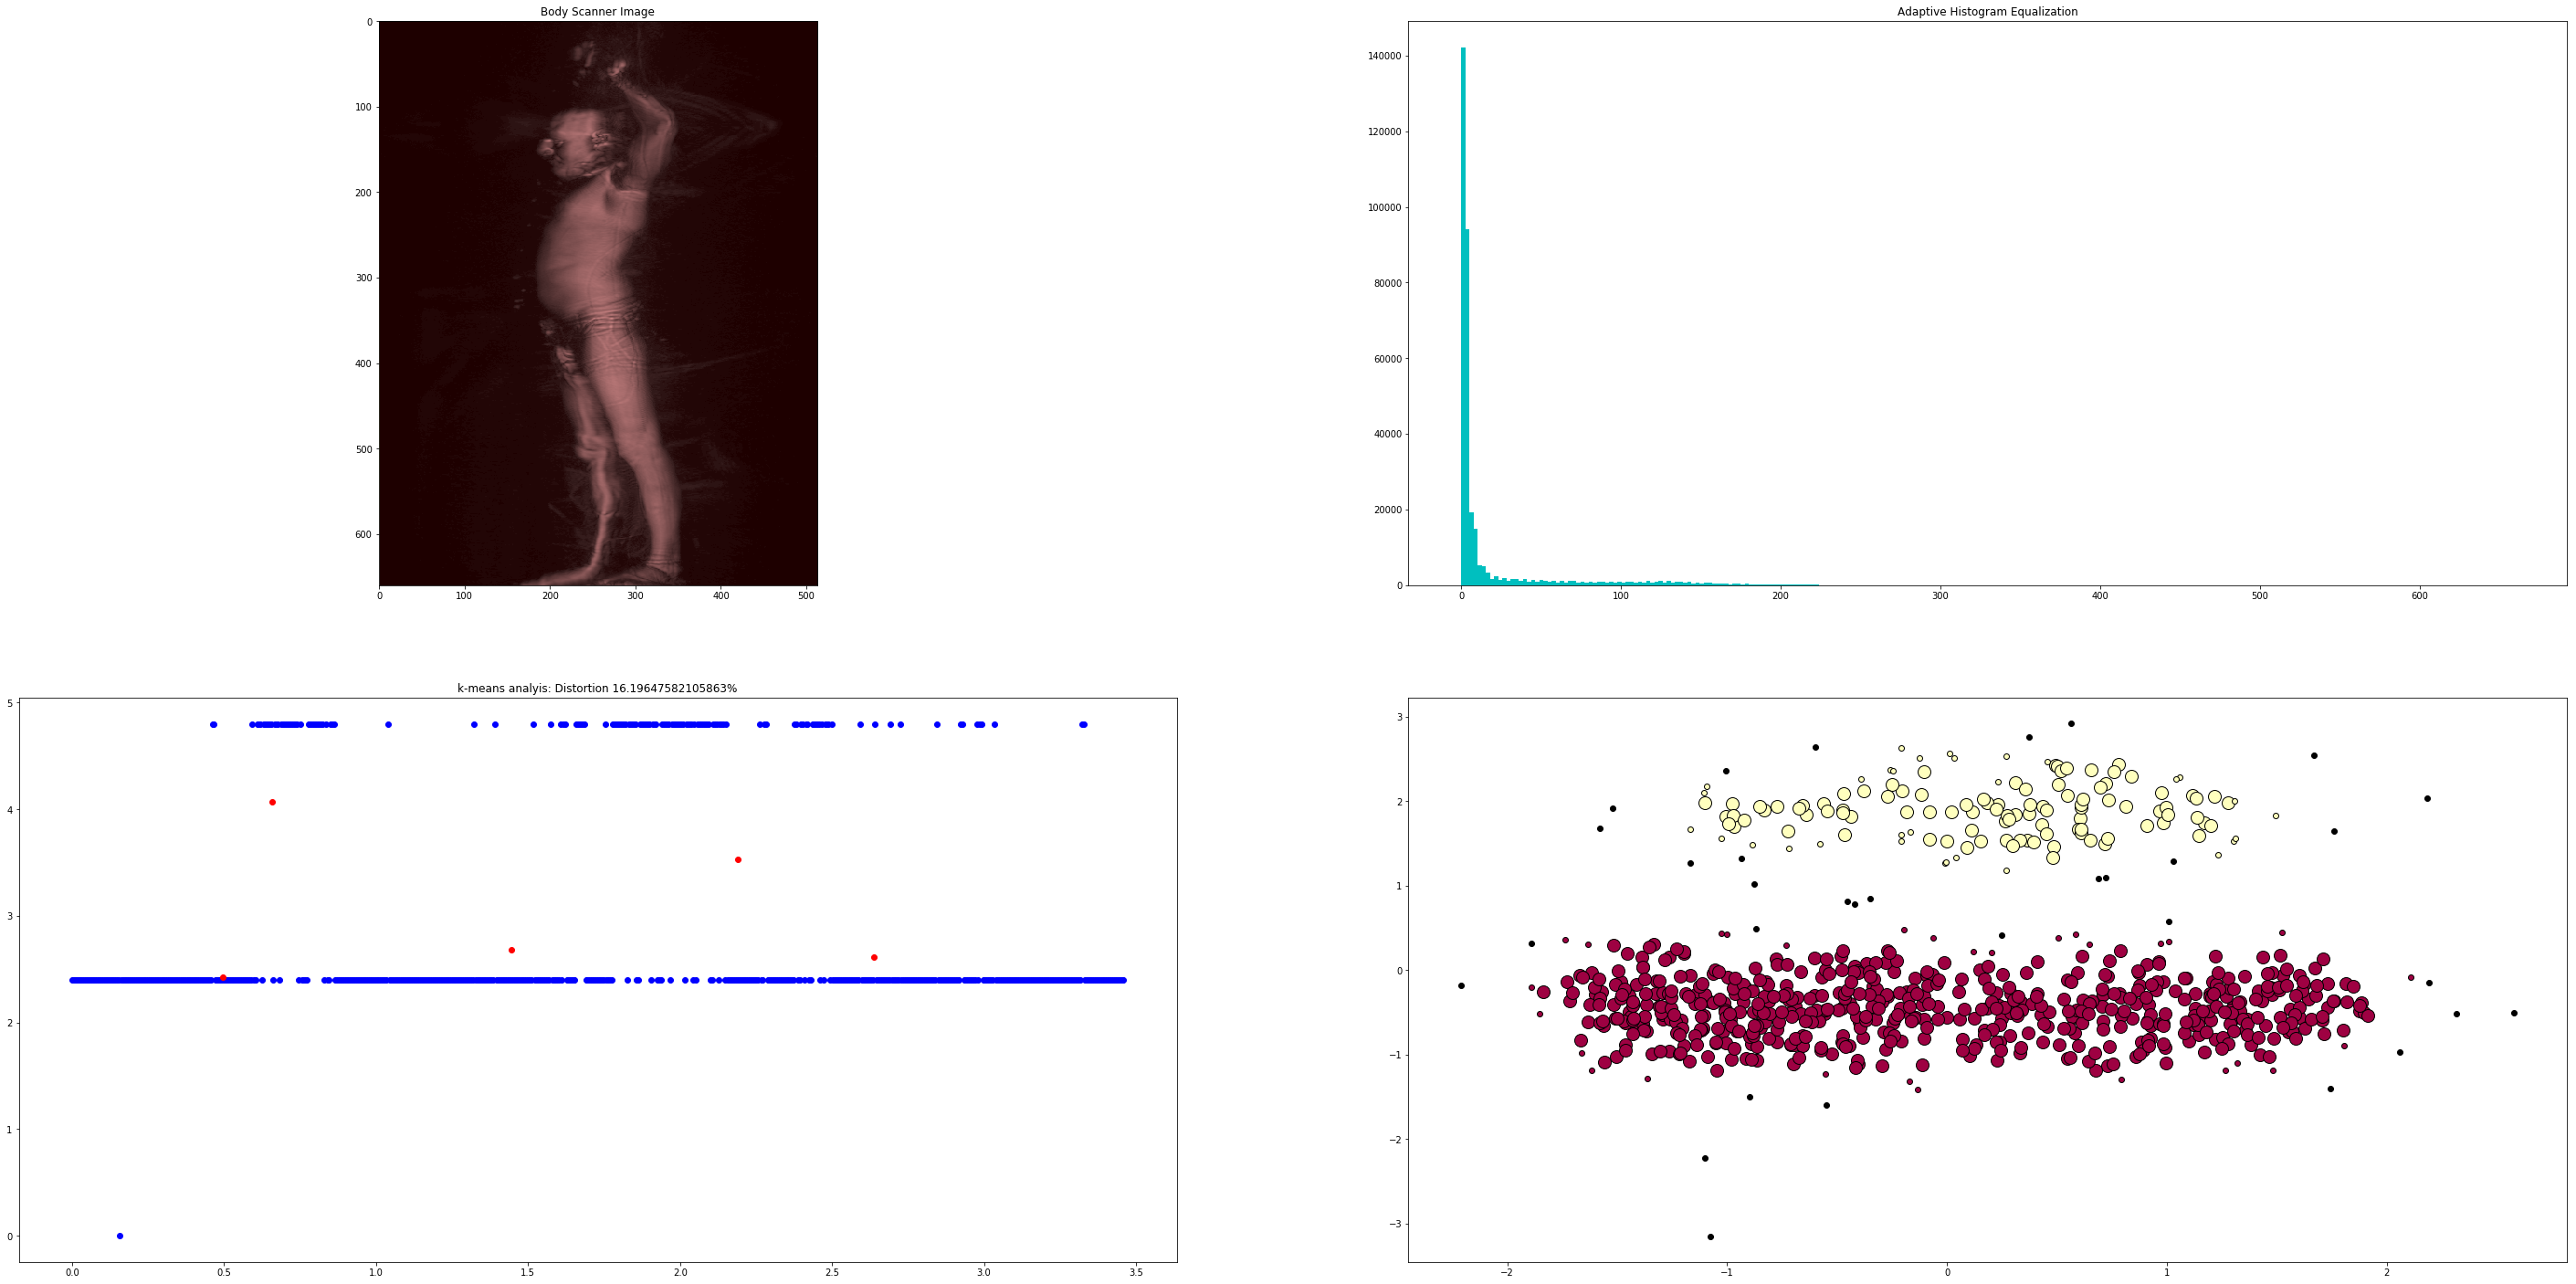

Image Distortion 67.302246683903


In [10]:
if __name__ == "__main__":
	print ("DATA_ANALISIS_TOOL: Initialization of the system...")
	distortion_indicator1=0
	try:
		dataset = pd.read_csv(NAME_FILE_MODEL_KMEANS, sep=',')
		n_samp = len(dataset)
		X, y = make_classification(n_samples=n_samp, n_features=4, random_state=0)
		row = 0
		for index in range(len(dataset)):
			X[row][0]=dataset.loc[index,'Nth']
			X[row][1]=dataset.loc[index,'Distortion']
			X[row][2]=dataset.loc[index,'Difference']
			X[row][3]=dataset.loc[index,'Mean']
			if dataset.loc[index,'Threat'] == 'threat':
				y[index]=np.int32(1)
			else:
				y[index]=np.int32(0)
			
			row = row + 1
		clf = LinearSVC(random_state=0)
		clf.fit(X, y)
		dataset_new = pd.read_csv(DATA_FOR_PREDICTION_FILE, sep=',')
		data_array = np.array(dataset_new)
		print_img(data_array,title='Image under analysis')
		distortion,whitened,codebook = cluster_analisys(data_array)
		mean_value = dataset['Distortion'].mean()
		difference = abs(mean_value - distortion)
		distortion_indicator1 = difference / mean_value * 100
		nth = 3
		result_of_prediction = clf.predict([[nth,distortion,difference,mean_value]]) 	
		name_file = DATA_FOR_PREDICTION_FILE
		name_passenger = str(name_file).split('/')
		name_passenger = str(name_passenger[2]).split('.')
		name_passenger = name_passenger[0]
		
		if result_of_prediction == True:
			print("Passenger {0} it could suppose a thread at Body Scanner {1}".format(name_passenger,3))
			threat_result = True
		else:
			print("Passenger {0} it could suppose a thread at Body Scanner {1}".format(name_passenger,3))
		print_screen_results(data_array)
	except Exception as exception:
		print ("DATA_ANALISIS_TOOL: Excepcion {0}".format(exception))
	finally:
		print("Image Distortion {0}".format(distortion_indicator1))    


**Results SECTION 2: Prediction with svm algorithm over image with high contrast**

In a second approach we are detect that any anomalies could be produced by images with less quality. At this point we are going to apply to cleaning the datainput initial, based in an increase of high quality image with a filtering of the image datainput (contrast filtering techniques)

When we are tested the new results applying the same datainput and passed this input data across our support vector machine we can check in the output data that the results are better because we are reduced the distortion of the image and the model.

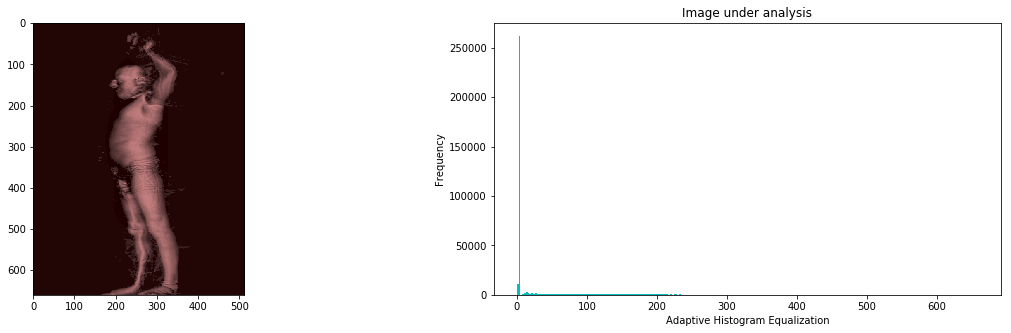

/opt/conda/lib/python3.6/site-packages/scipy/cluster/vq.py:141: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


Passenger highresolution it could suppose a thread at Body Scanner 3


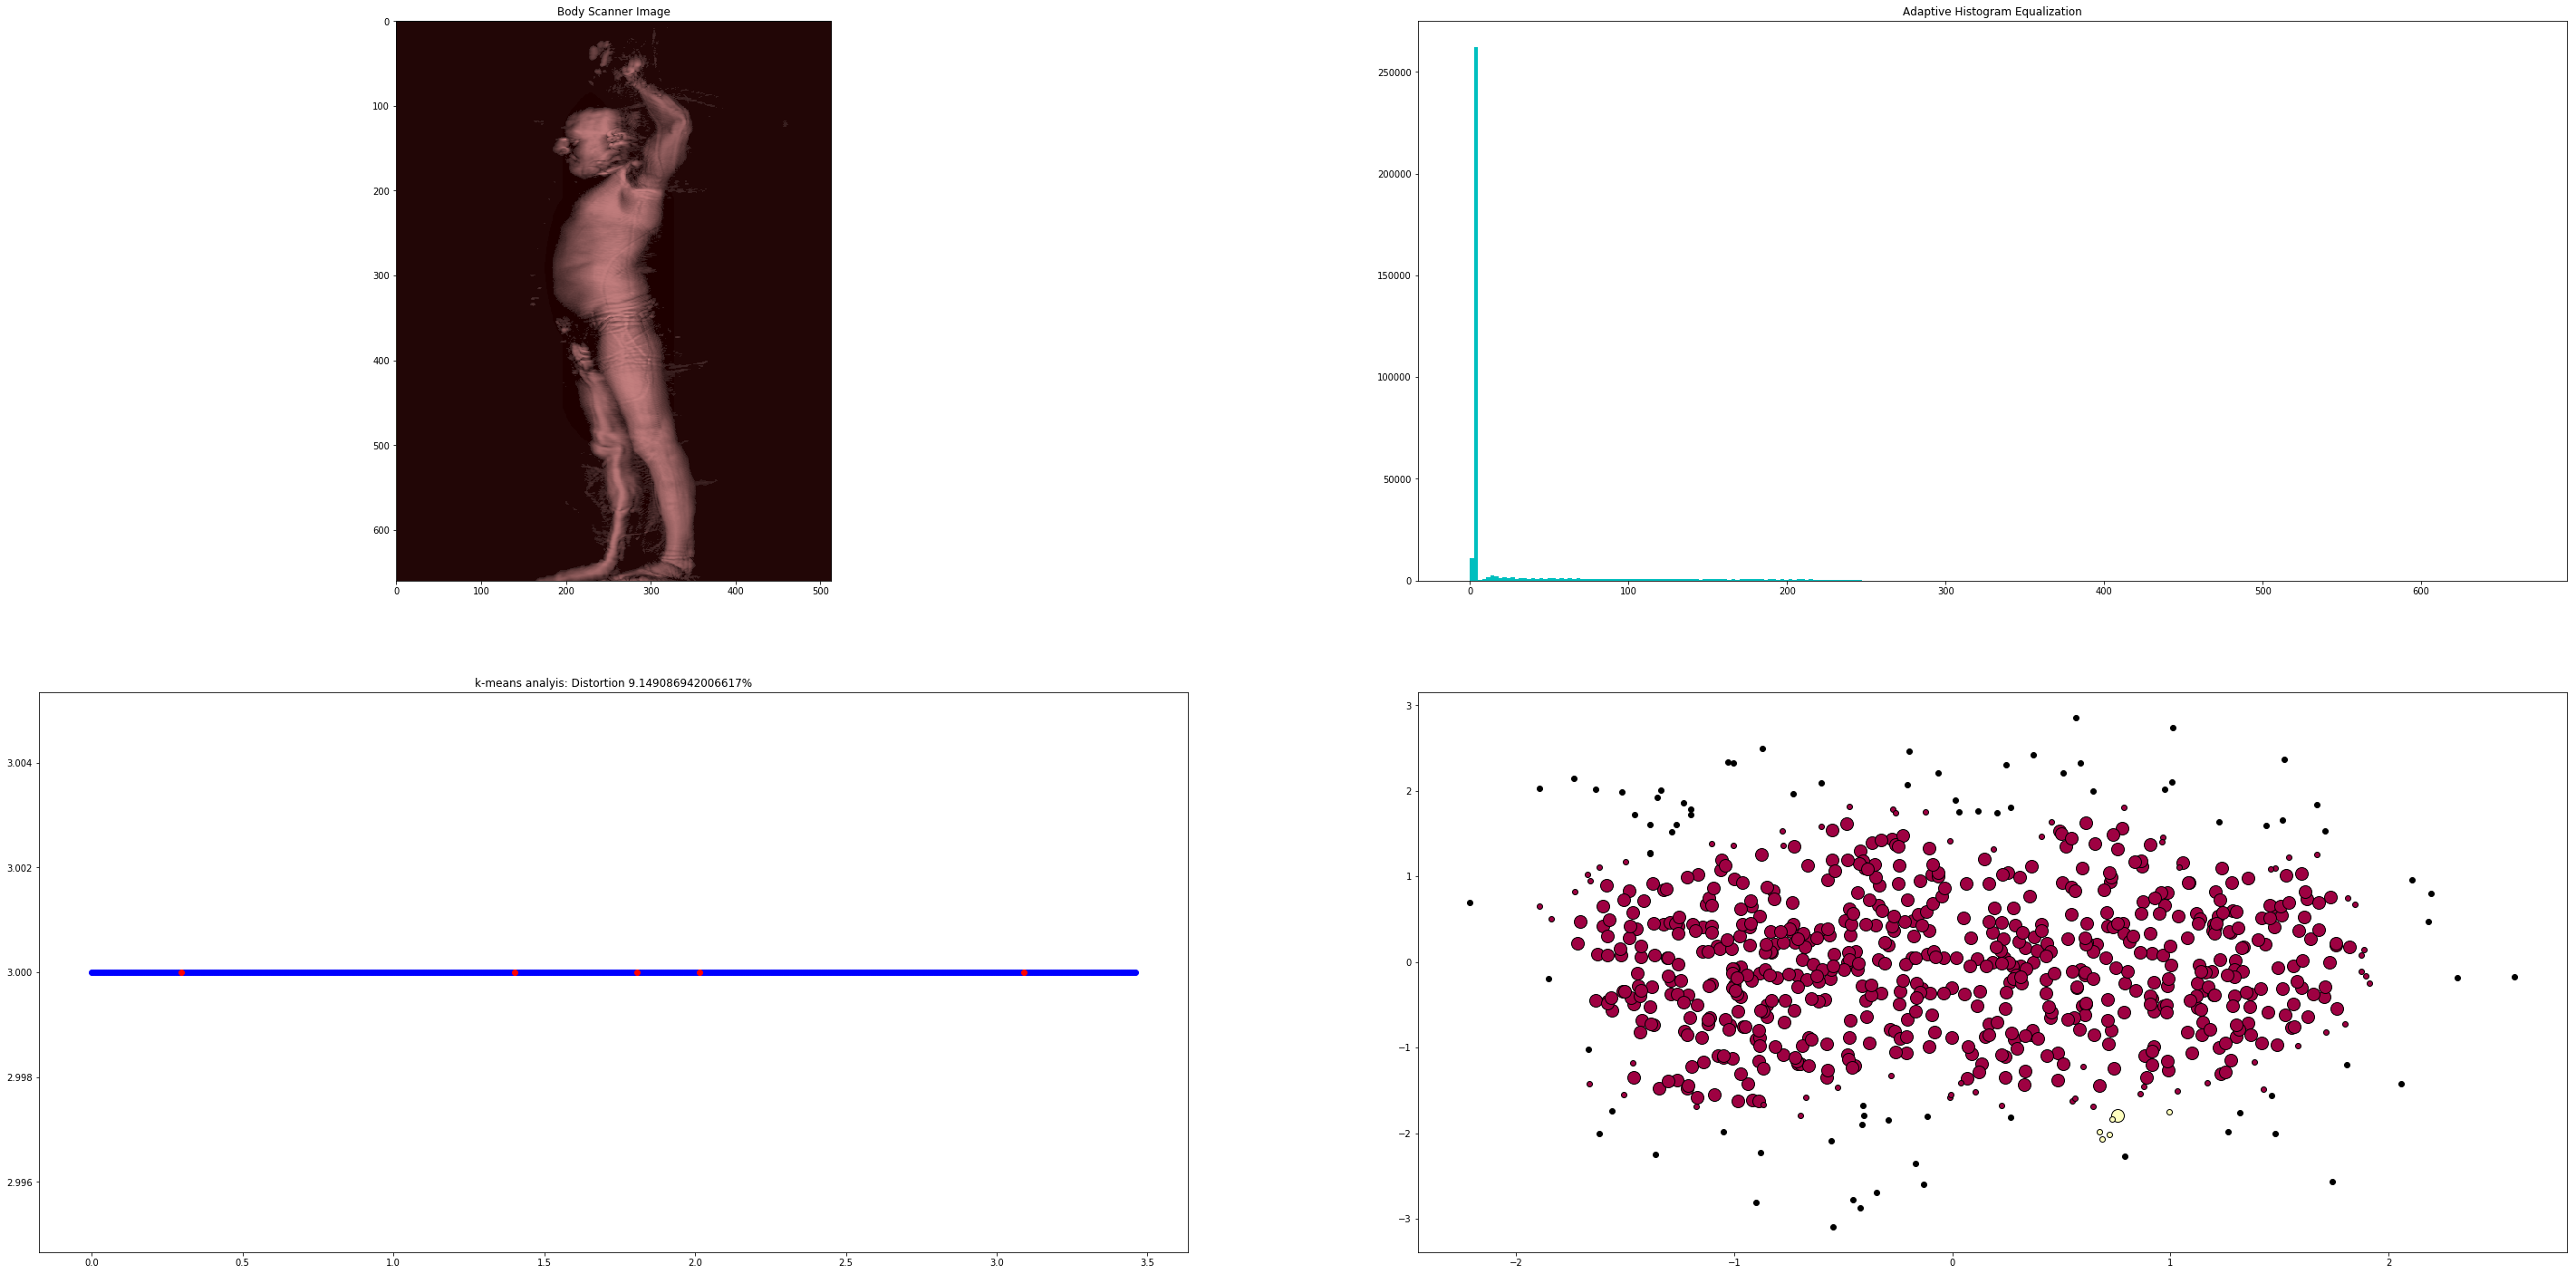

Image Distortion 5.610991225826779


In [11]:
try:
	name_file = DATA_FOR_PREDICTION_FILE_FILTERED
	dataset_new = pd.read_csv(DATA_FOR_PREDICTION_FILE_FILTERED, sep=',')
	data_array = np.array(dataset_new)
	print_img(data_array,title='Image under analysis')
	distortion,whitened,codebook = cluster_analisys(data_array)
	mean_value = dataset['Distortion'].mean()
	difference = abs(mean_value - distortion)
	distortion_indicator2 = difference / mean_value * 100
	nth = 3
	result_of_prediction = clf.predict([[nth,distortion,difference,mean_value]]) 	
	name_file = DATA_FOR_PREDICTION_FILE_FILTERED
	name_passenger = str(name_file).split('/')
	name_passenger = str(name_passenger[2]).split('.')
	name_passenger = name_passenger[0]
	if result_of_prediction == True:
		print("Passenger {0} it could suppose a thread at Body Scanner {1}".format(name_passenger,3))
		threat_result = True
	else:
		print("Passenger {0} it could suppose a thread at Body Scanner {1}".format(name_passenger,3))
	
	print_screen_results(data_array)
except Exception as exception:
	print ("DATA_ANALISIS_TOOL: Excepcion {0}".format(exception))
finally:
	print("Image Distortion {0}".format(distortion_indicator2)) 


**Improvement in detection images with filtering** 

Also we are try to apply any techniques of DBSCAN for identify possibles case of anomalies in the image, but this tasks required more time and the purposes of this practice for me it's only the application of the knowledge acquired in the course, with a simple method of clustering to find mistakes and possible anomalies that it could think us that the passenger could have any kind of threat object. With a simple application of a method of classification for the prediction such as support vector machine I think we could achieve our initial goals joining the clustering analysis and support vector machine ( classification method) in a useful programme for detect possible threats of passengers in the control of the airports.   

The improvement is found in the development of the practice with the application of image's cleaning techniques filtering obtaining a better difference results with respect the initial results around the mean value of image distortion, with an improvement in the distortion of image around of 0,61 reflected in the precession of the possible prediction.



In [12]:
improvement = distortion_indicator2 - distortion_indicator1
print("Image distortion improvement with the filtering image {0}% ".format(improvement))

Image distortion improvement with the filtering image -61.69125545807621% 
